# Check predictions

Creates an excel file with all predictions that have the confidence score for target object higher than 0.5

In [51]:
import json
import glob
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

os.makedirs('./labeled', exist_ok=True)

# Read predictions from JSON file
with open('./predictions.json', 'r') as f:
    predictions = json.load(f)

# Get all .jpg images in the ./detection folder
image_files = glob.glob('./images/test/*.JPG')

selected_images = []

# Loop through each image
for img_path in image_files:
    img_name = os.path.basename(img_path)
    image = cv2.imread(img_path)

    for pred in predictions:
        if pred.get('image_id') == img_name[:-4]:
            if pred.get('score') > 0.5 and pred.get('category_id') == 0:
                x, y, w, h = np.array(pred.get('bbox'), dtype=int)
                x_min, y_min = x, y
                x_max, y_max = x + w, y + h

                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 20)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                save_path = os.path.join('./labeled', img_name)
                plt.imsave(save_path, image_rgb)
                selected_images.append([img_name, pred.get('bbox')])

df = pd.DataFrame(selected_images, columns=['ImageName', 'BoundingBox'])
df.to_excel('images.xlsx', index=False)

# Create a list of all image information

Creates an excel with the image, lat, lon, yaw and timestamp information

In [50]:
from PIL import Image
import re
from draw_utils import get_exif_data, get_lat_lon
import matplotlib.pyplot as plt

def extract_exif_and_gimbal_yaw(image_path):
    img_exif = Image.open(image_path)
    exif_data = get_exif_data(img_exif)
    lat, lon = get_lat_lon(exif_data)

    timestamp = exif_data.get('DateTimeOriginal') or exif_data.get('DateTime')

    with open(image_path, encoding='latin-1') as fd:
        d = fd.read()
        xmp_start = d.find('<x:xmpmeta')
        xmp_end = d.find('</x:xmpmeta')
        xmp_str = d[xmp_start:xmp_end+12]
        match = re.search(r'drone-dji:GimbalYawDegree="([+-][\d.]+)"', xmp_str)
        gimbal_yaw = float(match.group(1)) if match else None

    return lat, lon, gimbal_yaw, timestamp

image_info = []

for img_name in df['ImageName']:
    img_path = os.path.join('./images/test', img_name)
    try:
        lat, lon, yaw, timestamp = extract_exif_and_gimbal_yaw(img_path)
    except Exception as e:
        lat, lon, yaw = None, None, None
    image_info.append({'ImageName': img_name, 'lat': lat, 'lon': lon, 'yaw': yaw, 'timestamp': timestamp})

info_df = pd.DataFrame(image_info)
info_df.to_excel('image_info.xlsx', index=False)


# image = './images/test/flight_23_DJI_0042.JPG'
# lat, lon, gimbal_yaw = extract_exif_and_gimbal_yaw(image)

# plt.figure(figsize=(12, 7))
# show = cv2.imread(image)
# show = cv2.cvtColor(show, cv2.COLOR_BGR2RGB)
# center = (show.shape[1] // 2, show.shape[0] // 2)
# rot_mat = cv2.getRotationMatrix2D(center, -gimbal_yaw, 1.0)  # negative for image coordinates
# rotated = cv2.warpAffine(show, rot_mat, (show.shape[1], show.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
# plt.imshow(rotated)
# plt.axis('off')
# plt.title("Image: " + os.path.basename(image))
# plt.show()

flight_23_DJI_0056.JPG
Center: 45.117240361111115, 14.195962583333333
Min lat: 45.11668708133837, Max lat: 45.11779364088386
Min lon: 14.195124356630847, Max lon: 14.19680081003582
BBox center: lat=45.11701292411566, lon=14.19598786328272


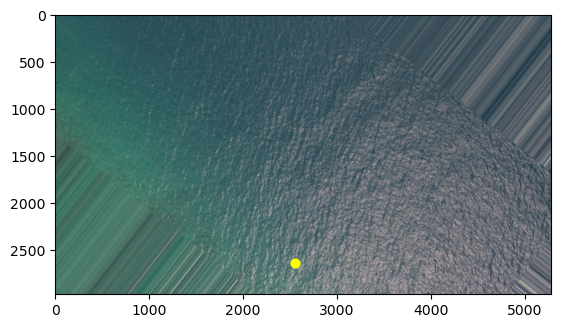

In [73]:
import os
from PIL import Image
from draw_utils import get_exif_data, get_lat_lon
import math
import numpy as np
import cv2

import matplotlib.pyplot as plt

def get_image_corners(img_width, img_height):
    # Returns corners in image coordinates (centered at image center)
    half_w = img_width / 2
    half_h = img_height / 2
    return np.array([
        [-half_w, -half_h],  # top-left
        [ half_w, -half_h],  # top-right
        [ half_w,  half_h],  # bottom-right
        [-half_w,  half_h],  # bottom-left
    ])

def rotate_points(points, angle_deg):
    # Rotates points by angle_deg (counterclockwise)
    theta = np.deg2rad(angle_deg)
    rot_mat = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    return points @ rot_mat.T

def image_corners_to_latlon(center_lat, center_lon, yaw_deg, img_width, img_height, gsd):
    # gsd: ground sample distance in meters per pixel
    # Returns lat/lon for each corner
    # Approximate: assumes flat earth and small area
    corners = get_image_corners(img_width, img_height)
    rotated = rotate_points(corners, yaw_deg)
    # Convert meters to lat/lon offsets
    # 1 deg latitude ~ 111320 m, 1 deg longitude ~ 111320*cos(lat) m
    dlat = rotated[:,1] * gsd / 111320
    dlon = rotated[:,0] * gsd / (111320 * np.cos(np.deg2rad(center_lat)))
    lats = center_lat + dlat
    lons = center_lon + dlon
    return lats, lons

# Example for one image
img_row = info_df.iloc[10]  # last image as example
img_name = img_row['ImageName']
print(img_name)
center_lat = img_row['lat']
center_lon = img_row['lon']
yaw = img_row['yaw']
img_path = os.path.join('./images/test', img_name)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_height, img_width = img.shape[:2]

# Estimate GSD (ground sample distance) in meters/pixel
# If you know the real GSD, set it here. Otherwise, use an approximate value.
# For DJI MFT 15mm F1.7 ASPH, at 100m AGL, GSD ~ 2.2 cm/pixel
gsd = 0.022  # meters/pixel (adjust as needed)

center = (img.shape[1] // 2, img.shape[0] // 2)
rot_mat = cv2.getRotationMatrix2D(center, -yaw, 1.0)  # negative for image coordinates
rotated = cv2.warpAffine(img, rot_mat, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
plt.imshow(rotated)

lats, lons = image_corners_to_latlon(center_lat, center_lon, yaw, img_width, img_height, gsd)
min_lat, max_lat = lats.min(), lats.max()
min_lon, max_lon = lons.min(), lons.max()

corners = get_image_corners(img_width, img_height)
rotated_corners = rotate_points(corners, yaw)
img_corners_xy = rotated_corners + np.array([img_width/2, img_height/2])

print(f"Center: {center_lat}, {center_lon}")
print(f"Min lat: {min_lat}, Max lat: {max_lat}")
print(f"Min lon: {min_lon}, Max lon: {max_lon}")

# Get the bounding box for this image from df
bbox_row = df[df['ImageName'] == img_name]
if not bbox_row.empty:
    bbox = bbox_row.iloc[0]['BoundingBox']
    # Convert bbox to OpenCV format [x_min, y_min, x_max, y_max]
    x_min, y_min, w, h = bbox
    x_max = x_min + w
    y_max = y_min + h
    opencv_bbox = [x_min, y_min, x_max, y_max]

    # Draw rectangle on the rotated image (need to rotate bbox corners as well)
    # Get bbox corners in image coordinates (before rotation)
    # Get bbox center in image coordinates
    bbox_center = np.array([
        x_min + (x_max - x_min) / 2,
        y_min + (y_max - y_min) / 2
    ])
    # Center at image center
    bbox_center_centered = bbox_center - np.array([img_width/2, img_height/2])
    # Rotate by yaw
    bbox_center_rot = rotate_points(bbox_center_centered.reshape(1, 2), yaw)[0]
    # Move back to image coordinates
    bbox_center_img = bbox_center_rot + np.array([img_width/2, img_height/2])

    # Draw center point on rotated image
    plt.scatter([bbox_center_img[0]], [bbox_center_img[1]], color='yellow', s=40)

    # Convert bbox center to lat/lon
    dlat = bbox_center_rot[1] * gsd / 111320
    dlon = bbox_center_rot[0] * gsd / (111320 * np.cos(np.deg2rad(center_lat)))
    if bbox_center[1] < img_height / 2:
        dlat = -dlat
    else:
        dlat = dlat
        
    if bbox_center[0] > img_width / 2:
        dlon = dlon
    else:
        dlon = -dlon

    bbox_center_lat = center_lat + dlat
    bbox_center_lon = center_lon + dlon

    print(f"BBox center: lat={bbox_center_lat}, lon={bbox_center_lon}")

else:
    print("No bounding box found for this image.")

In [28]:
import folium
import pandas as pd

# Load image info with lat/lon
info_df = pd.read_excel('image_info.xlsx')

# Center map at the mean location
center_lat = info_df['lat'].mean()
center_lon = info_df['lon'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=16)

# Add markers for each image
for _, row in info_df.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=row['ImageName'],
        icon=folium.Icon(color='blue', icon='camera', prefix='fa')
    ).add_to(m)

m.save('image_locations_map.html')
m

In [47]:
def json_bbox_to_yolo_bbox(bbox, img_width, img_height):
    """
    Convert COCO JSON bbox format [x_min, y_min, width, height] to YOLO format [x_center, y_center, w, h] (normalized).
    bbox: list or tuple of [x_min, y_min, width, height]
    img_width: int, image width in pixels
    img_height: int, image height in pixels
    Returns: [x_center_norm, y_center_norm, w_norm, h_norm]
    """
    x_min, y_min, w, h = bbox
    x_center = x_min + w / 2
    y_center = y_min + h / 2
    x_center_norm = x_center / img_width
    y_center_norm = y_center / img_height
    w_norm = w / img_width
    h_norm = h / img_height
    return [x_center_norm, y_center_norm, w_norm, h_norm]

In [48]:
def yolo_bbox_to_opencv_bbox(yolo_bbox, img_width, img_height):
    """
    Convert YOLO bbox format [x_center, y_center, w, h] (normalized) to OpenCV format [x_min, y_min, x_max, y_max] (pixels).
    yolo_bbox: list or tuple of [x_center, y_center, w, h] (all normalized)
    img_width: int, image width in pixels
    img_height: int, image height in pixels
    Returns: [x_min, y_min, x_max, y_max] (all int)
    """
    x_center, y_center, w, h = yolo_bbox
    x_center_px = x_center * img_width
    y_center_px = y_center * img_height
    w_px = w * img_width
    h_px = h * img_height

    x_min = int(round(x_center_px - w_px / 2))
    y_min = int(round(y_center_px - h_px / 2))
    x_max = int(round(x_center_px + w_px / 2))
    y_max = int(round(y_center_px + h_px / 2))

    return [x_min, y_min, x_max, y_max]